In [81]:
%reload_ext kedro.ipython

[09/29/25 12:38:19] INFO     Registered line magic '%reload_kedro'                                   ]8;id=129948;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=940641;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=741064;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=988194;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=96557;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=668539;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /Users/eoinmolloy/Documents/Documents/FPL-Modelling/fpl-modelling.                    
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=907226;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=594154;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro_telemetry/plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

                    INFO     Kedro project fpl_modelling                                            ]8;id=902760;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=759320;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=103773;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=578600;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

In [82]:
p_hist = catalog.load("players_hist_merged")

                    INFO     Loading data from players_hist_merged (SQLQueryDataset)...        ]8;id=948485;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751771;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#1046\1046]8;;\

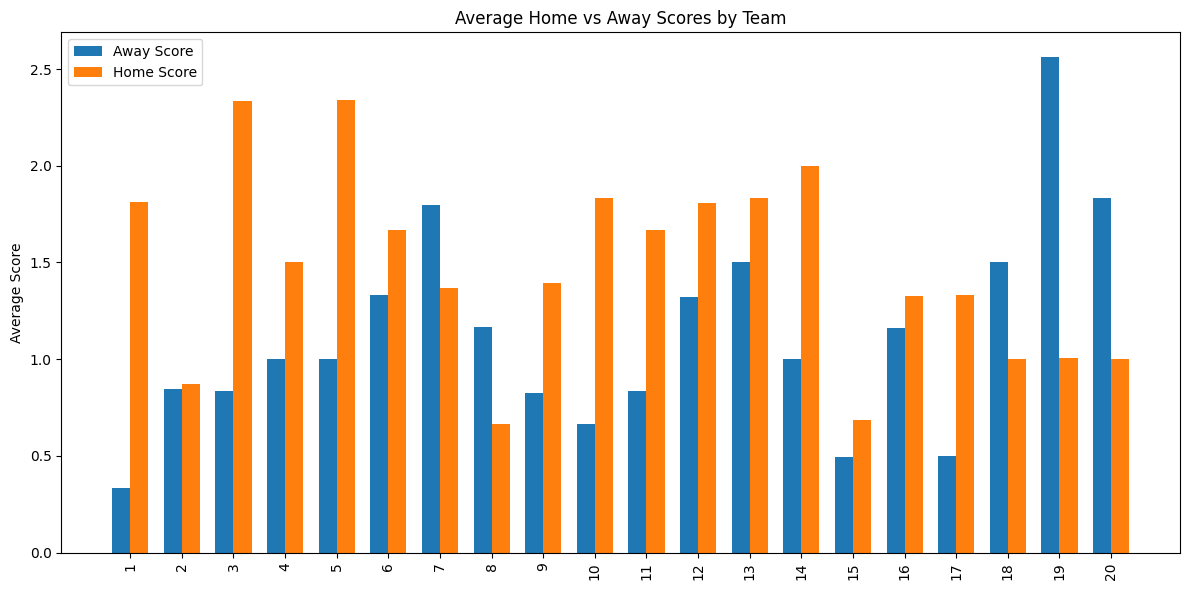

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Group by team, take mean across all gameweeks
avg_scores = team_scores.groupby("team_id")[["team_a_score", "team_h_score"]].mean()

# Plot
x = np.arange(len(avg_scores))  # team positions
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, avg_scores["team_a_score"], width, label="Away Score")
ax.bar(x + width/2, avg_scores["team_h_score"], width, label="Home Score")

ax.set_xticks(x)
ax.set_xticklabels(avg_scores.index, rotation=90)
ax.set_ylabel("Average Score")
ax.set_title("Average Home vs Away Scores by Team")
ax.legend()

plt.tight_layout()
plt.show()


In [84]:
p_hist['form'] = p_hist['form'].astype(float)

p_hist_r5 = p_hist[p_hist['round']==5]
p_hist_r6 = p_hist[p_hist['round']==6]
p_hist_r6 = p_hist_r6[p_hist_r6['player_name']!='Ryan McAidoo']

In [85]:
import numpy as np 

np.corrcoef(p_hist_r5['form'].values, p_hist_r6['round_points'].values)


array([[1.        , 0.69887246],
       [0.69887246, 1.        ]])

In [86]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.reset_option("display.max_rows")


In [ ]:
num_features = [
    'form',
    'selected_by_percent'
]
cat_features = [
    'players_team_strength',
    'opponent_team_strength',
    ]

In [98]:
X = p_hist_r5[num_features+cat_features]
y = p_hist_r6['round_points']

In [101]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, KFold

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# Models
linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

dummy = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", DummyRegressor(strategy="mean"))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics we want
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
    "MAPE": "neg_mean_absolute_percentage_error"
}

def evaluate(model, name):
    results = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    print(f"\n{name} results:")
    for metric in scoring.keys():
        train_scores = results[f"train_{metric}"]
        test_scores = results[f"test_{metric}"]

        # Convert negatives back for MAE, RMSE, MAPE
        if metric in ["MAE", "RMSE", "MAPE"]:
            train_scores = -train_scores
            test_scores = -test_scores

        print(f"{metric} - Train (per fold): {train_scores}")
        print(f"{metric} - Test  (per fold): {test_scores}")
        print(f"{metric} - Avg Train: {train_scores.mean():.4f}")
        print(f"{metric} - Avg Test : {test_scores.mean():.4f}\n")

    return results

linreg_results = evaluate(linreg, "Linear Regression")
dummy_results = evaluate(dummy, "Dummy Regressor")



Linear Regression results:
MAE - Train (per fold): [0.81962037 0.82889909 0.76399467 0.83783857 0.77004485]
MAE - Test  (per fold): [0.77180435 0.87954343 0.85394665 0.72791314 0.92874609]
MAE - Avg Train: 0.8041
MAE - Avg Test : 0.8324

RMSE - Train (per fold): [1.56024295 1.5956135  1.50390502 1.58985933 1.49997686]
RMSE - Test  (per fold): [1.54500133 1.42127612 1.76033451 1.42079538 1.80377573]
RMSE - Avg Train: 1.5499
RMSE - Avg Test : 1.5902

R2 - Train (per fold): [0.51502559 0.53758101 0.49522333 0.51755212 0.46705271]
R2 - Test  (per fold): [0.45058438 0.16621167 0.52186796 0.42471093 0.56859122]
R2 - Avg Train: 0.5065
R2 - Avg Test : 0.4264

MAPE - Train (per fold): [1.20079959e+15 1.30156757e+15 1.07757629e+15 1.26522988e+15
 1.14959418e+15]
MAPE - Test  (per fold): [1.21761467e+15 1.33565154e+15 1.14732474e+15 1.05041947e+15
 1.44563723e+15]
MAPE - Avg Train: 1198953501379099.7500
MAPE - Avg Test : 1239329527978024.7500


Dummy Regressor results:
MAE - Train (per fold): [1